In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import pickle
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import itertools

from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras.layers import Add, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from src.explore import explore_data, create_dis_rating, top_reviewers, top_products, sub_dataset
from src.cf_models import import_data, create_parameters_model, train_test, RecommenderNet

pd.set_option('display.float_format', '{:.2f}'.format)

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
data = pd.read_csv('../data/data_2018_clean.csv')

In [5]:
# data structure
data.head(3)

,Unnamed: 0,rating,reviewTime,reviewerID,movieID,style,reviewerName,reviewText,summary,unixReviewTime,...,category,title,main_cat,description,brand,price,links,reviewer_count,movie_count,average_rating
0,0,5.00,"04 8, 2018",A1CW3NLH9MBQRY,6303022901,{'Format:': ' DVD'},Sally Nunez,I really enjoyed this movie. Brings tears to m...,Five Stars,1523145600,...,"['Movies & TV', 'Genre for Featured Categories...",The Joy Luck Club VHS,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,3,21,4.86
1,1,5.00,"04 2, 2018",A1WK0IRZ08NX9X,6303022901,{'Format:': ' DVD'},Ammie28,"If you have never seen this movie, you may jus...",Heart Touching...,1522627200,...,"['Movies & TV', 'Genre for Featured Categories...",The Joy Luck Club VHS,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,4,21,4.86
2,2,5.00,"03 30, 2018",A2HGXJQCQTXE4E,6303022901,{'Format:': ' Blu-ray'},Pa nhia lee,awesome all time fave movie.,Five Stars,1522368000,...,"['Movies & TV', 'Genre for Featured Categories...",The Joy Luck Club VHS,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,4,21,4.86


In [6]:
# explore the dataset of 2018 
explore_data()

Count of Reviewers: 119945
Count of Products: 38846

Ratings descriptive statistics: 
count   209060.00
mean         4.34
std          1.23
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: rating, dtype: float64

Reviewers by count descriptive statistics: 
count   119945.00
mean         1.74
std          2.37
min          1.00
25%          1.00
50%          1.00
75%          2.00
max        110.00
Name: rating, dtype: float64

Products by count descriptive statistics: 
count   38846.00
mean        5.38
std        17.19
min         1.00
25%         1.00
50%         2.00
75%         4.00
max       959.00
Name: rating, dtype: float64

Top reviwers by count of reviews: 
reviewerID
AJ2LH4FFW4QYX     110
A3QXT4RO4RBPCL     99
A5RGNTKP1A87U      98
A471W6ANJU6W9      86
A1ADJ8AD91RE0J     82
AG8OC1AEP44WU      82
A2764UZVBFC61W     80
A3EKNWZOV3EZXC     79
AGB3M4QPM0MIU      78
A54ERXXP81MF       75
AVBJBOK7CQTEQ      71
A1UI1DY6CPWHY5     69
A3H

In [7]:
ratings_2018, top_reviewers, top_products = sub_dataset()

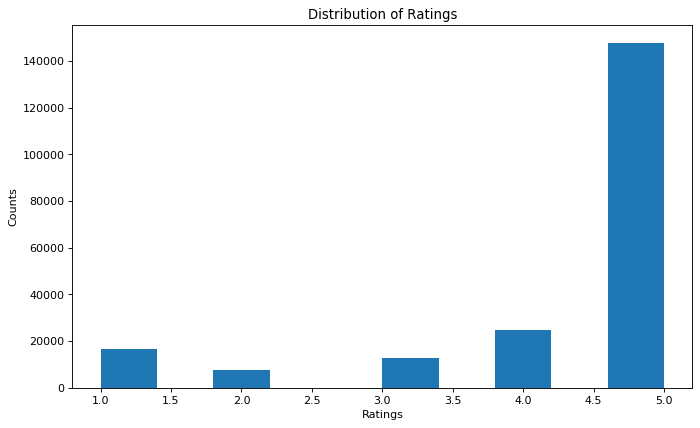

In [8]:
# distribution of ratings
rating_hist = create_dis_rating(ratings_2018)

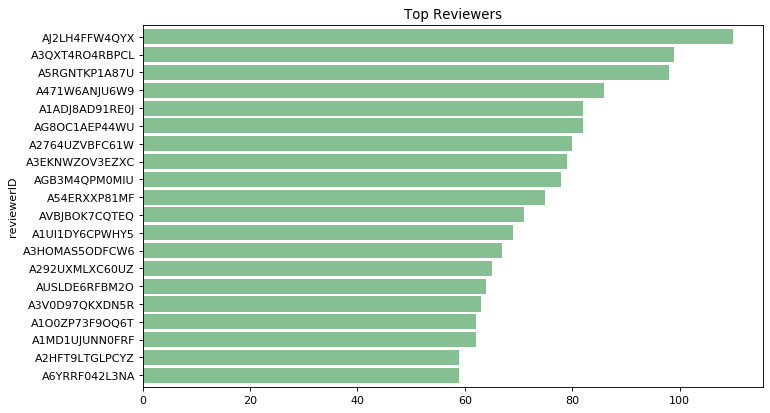

In [9]:
# top reviewers
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
top_reviewers.sort_values().plot(kind='barh',color='#86bf91', zorder=2, width=0.85)
plt.title('Top Reviewers')
    
plt.show()

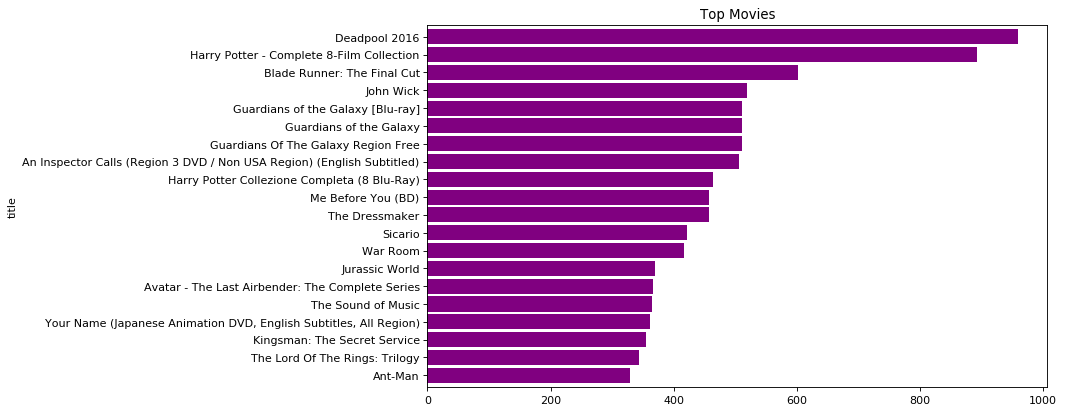

In [10]:
# top products
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

top_products.sort_values().plot(kind='barh', zorder=2, color='purple', width=0.85)
plt.title('Top Movies')

plt.show()

## Findings:

1. Majority ratings are 5.
2. 50% reviewers only reviewed 1 movie.
3. 25% movies have only one review. 
4. Data is sparse. 

In [3]:
# import cleaned data for model 
data_2018 = import_data()

In [4]:
# get parameters for the model
n_reviewers, n_movies, n_factors, min_rating, max_rating = create_parameters_model(data_2018)

In [5]:
# split train and test data for the model
X_train, X_test, X_train_array, X_test_array, y_train, y_test = train_test(data_2018)

In [6]:
# initialate the model
model = RecommenderNet(n_reviewers, n_movies, n_factors, min_rating, max_rating)

In [7]:
# fit the data
history = model.fit(x=X_train_array, 
                    y=y_train, 
                    batch_size=64, 
                    epochs=5,
                    verbose=1, 
                    validation_data=(X_test_array, y_test))

Train on 93360 samples, validate on 23340 samples
Epoch 1/5


/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


93360/93360 [==============================] - 29s 310us/sample - loss: 1.2747 - mae: 0.7780 - val_loss: 0.8710 - val_mae: 0.5021
Epoch 2/5
93360/93360 [==============================] - 27s 289us/sample - loss: 0.7034 - mae: 0.4500 - val_loss: 0.8013 - val_mae: 0.4580
Epoch 3/5
93360/93360 [==============================] - 27s 287us/sample - loss: 0.5478 - mae: 0.3690 - val_loss: 0.7736 - val_mae: 0.4444
Epoch 4/5
93360/93360 [==============================] - 27s 287us/sample - loss: 0.4710 - mae: 0.3250 - val_loss: 0.7839 - val_mae: 0.4403
Epoch 5/5
93360/93360 [==============================] - 27s 285us/sample - loss: 0.4368 - mae: 0.3043 - val_loss: 0.7858 - val_mae: 0.4322


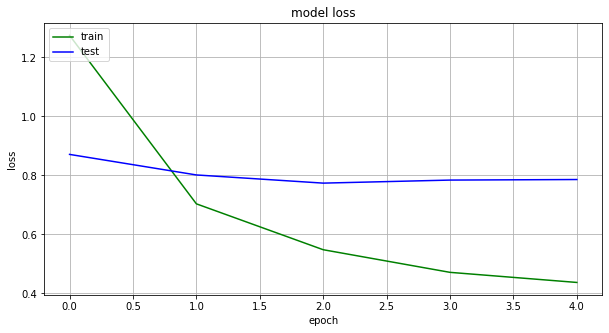

In [8]:
# visualize the loss
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [9]:
# load the recommeder
from src.recommend_movies import recommender

In [10]:
rec = recommender(1000)

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [11]:
rec

,movie,title,average_rating,category,description,price,links
19449,1162,Lean on Me,4.86,"['Movies & TV', 'Studio Specials', 'Warner Hom...",['Based on the true story of new jersey high s...,$15.00,https://www.amazon.com/product-reviews/6305133...
20855,2499,The Family Man,5.00,"['Movies & TV', 'Genre for Featured Categories...",NaN,$22.31,https://www.amazon.com/product-reviews/B000057...
34954,18583,Back to the Future 30th Anniversary Trilogy,4.59,"['Movies & TV', 'Boxed Sets', 'Comedy']",['Experience the future all over again with th...,$22.51,https://www.amazon.com/product-reviews/B011Q0F...
60138,4300,Evelyn,4.83,"['Movies & TV', 'Studio Specials', 'MGM Home E...","[""From the director of Driving Miss Daisy come...",$16.67,https://www.amazon.com/product-reviews/B00008D...
85188,15127,Futurama: The Complete Series,4.38,"['Movies & TV', 'Studio Specials', '20th Centu...",['As vast and hilarious as the universe itself...,$68.45,https://www.amazon.com/product-reviews/B00F77M...


## Cross validation

In [12]:
from src.cross_val import cross_val_v1

In [13]:
cvscores, cvscore_mean, cvscore_std = cross_val_v1(X_train, y_train)

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 74688 samples, validate on 18672 samples
Epoch 1/5
   32/74688 [..............................] - ETA: 11:21 - loss: 0.1892 - mae: 0.1751

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


74688/74688 [==============================] - 44s 587us/sample - loss: 0.3979 - mae: 0.2882 - val_loss: 0.3012 - val_mae: 0.2180
Epoch 2/5
74688/74688 [==============================] - 43s 580us/sample - loss: 0.3988 - mae: 0.2888 - val_loss: 0.3858 - val_mae: 0.2677
Epoch 3/5
74688/74688 [==============================] - 46s 610us/sample - loss: 0.4055 - mae: 0.2932 - val_loss: 0.4904 - val_mae: 0.3177
Epoch 4/5
74688/74688 [==============================] - 45s 608us/sample - loss: 0.4021 - mae: 0.2911 - val_loss: 0.6424 - val_mae: 0.3727
Epoch 5/5
18672/18672 [==============================] - 2s 86us/sample - loss: 0.7363 - mae: 0.4074
mae 0.40737972
Train on 74688 samples, validate on 18672 samples
Epoch 1/5
74688/74688 [==============================] - 45s 600us/sample - loss: 0.5047 - mae: 0.3394 - val_loss: 0.3264 - val_mae: 0.2381
Epoch 2/5
74688/74688 [==============================] - 48s 642us/sample - loss: 0.4391 - mae: 0.3086 - val_loss: 0.4217 - val_mae: 0.2807
Epoc

In [17]:
cvscores

[0.40737972, 0.40187737, 0.384637, 0.3743945, 0.38229263]

In [18]:
cvscore_mean, cvscore_std

(0.39011627, 0.012447937)